In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import tensorflow as tf

# Generating synthetic data for protein-protein interactions
def generate_synthetic_data(n_samples=1000, n_features=20, n_interactions=200, test_size=0.2, random_seed=42):
    np.random.seed(random_seed)

    # Generate random features for proteins
    X = np.random.randn(n_samples, n_features)

    # Generate labels (0 for non-interactions, 1 for interactions)
    y = np.zeros(n_samples)
    interacting_indices = np.random.choice(n_samples, n_interactions, replace=False)
    y[interacting_indices] = 1

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_seed)

    return X_train, X_test, y_train, y_test

# Creating a simple CNN model with regularization and dropout
def create_cnn_model(input_shape, dropout_rate=0.2, l2_weight=0.01):
    model = models.Sequential()
    model.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape,
                            kernel_regularizer=tf.keras.regularizers.l2(l2_weight)))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_weight)))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Generate synthetic data
X_train, X_test, y_train, y_test = generate_synthetic_data()

# Reshape the data to fit into the CNN model
input_shape = (X_train.shape[1], 1)
X_train = X_train.reshape((-1, X_train.shape[1], 1))
X_test = X_test.reshape((-1, X_test.shape[1], 1))

# Define dropout rate and L2 weight for regularization
dropout_rate = 0.2
l2_weight = 0.01

# Create the CNN model with dropout and L2 regularization
model = create_cnn_model(input_shape, dropout_rate=dropout_rate, l2_weight=l2_weight)

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# Define k-fold cross-validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Train and evaluate the model using cross-validation
f1_scores = []
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Train the model with early stopping for each fold
    history = model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, validation_data=(X_val_fold, y_val_fold),
                        callbacks=[early_stopping])

    # Generate predictions on the validation set
    y_val_pred_probs = model.predict(X_val_fold)
    y_val_pred = (y_val_pred_probs > 0.2).astype(int)

    # Compute the F1 score for this fold
    f1_fold = f1_score(y_val_fold, y_val_pred)
    f1_scores.append(f1_fold)

# Calculate the mean F1 score across all folds
mean_f1_score = np.mean(f1_scores)
print("Mean F1 Score:", mean_f1_score)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

Epoch 1/10
20/20 [==============================] - 1s 22ms/step - loss: 1.4633 - accuracy: 0.7844 - val_loss: 1.3138 - val_accuracy: 0.8000
Epoch 2/10
20/20 [==============================] - 0s 14ms/step - loss: 1.1826 - accuracy: 0.8047 - val_loss: 1.0789 - val_accuracy: 0.8000
Epoch 3/10
20/20 [==============================] - 0s 13ms/step - loss: 0.9815 - accuracy: 0.8047 - val_loss: 0.9160 - val_accuracy: 0.8000
Epoch 4/10
20/20 [==============================] - 0s 9ms/step - loss: 0.8378 - accuracy: 0.8047 - val_loss: 0.8036 - val_accuracy: 0.8000
Epoch 5/10
20/20 [==============================] - 0s 14ms/step - loss: 0.7422 - accuracy: 0.8047 - val_loss: 0.7276 - val_accuracy: 0.8000
Epoch 6/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6760 - accuracy: 0.8047 - val_loss: 0.6731 - val_accuracy: 0.8000
Epoch 7/10
20/20 [==============================] - 0s 16ms/step - loss: 0.6303 - accuracy: 0.8047 - val_loss: 0.6370 - val_accuracy: 0.8000
Epoch 8/10
20/

7/7 [==============================] - 0s 5ms/step - loss: 0.5828 - accuracy: 0.7850
Test loss: 0.5827513337135315
Test accuracy: 0.7850000262260437
Final training accuracy: 0.8062499761581421


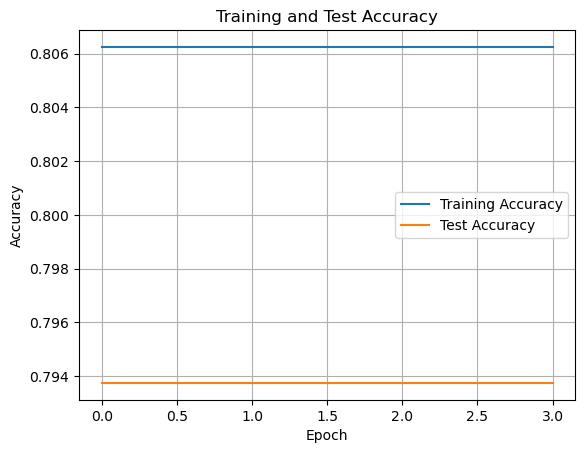

7/7 [==============================] - 0s 8ms/step


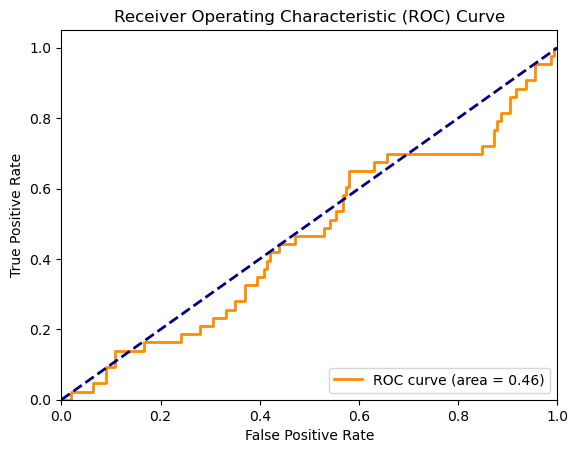

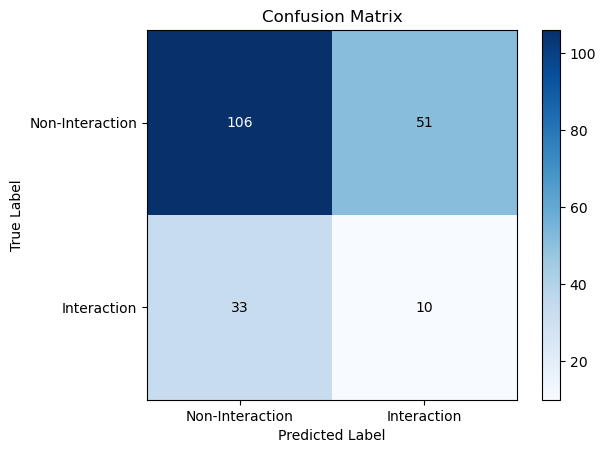

In [20]:
from sklearn.metrics import roc_curve, auc, confusion_matrix,f1_score
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

# Print the training accuracy
train_accuracy = history.history['accuracy'][-1]
print("Final training accuracy:", train_accuracy)

# Plot the training and test accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Generate predictions on the test set
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.2).astype(int)

# Compute the ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Compute and plot the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Non-Interaction', 'Interaction'])
plt.yticks([0, 1], ['Non-Interaction', 'Interaction'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations to the confusion matrix
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(conf_mat[i, j]), ha='center', va='center', color='white' if conf_mat[i, j] > conf_mat.max() / 2 else 'black')

plt.show()


7/7 [==============================] - 0s 10ms/step
Best Threshold for F1 Score: 0.05050505050505051


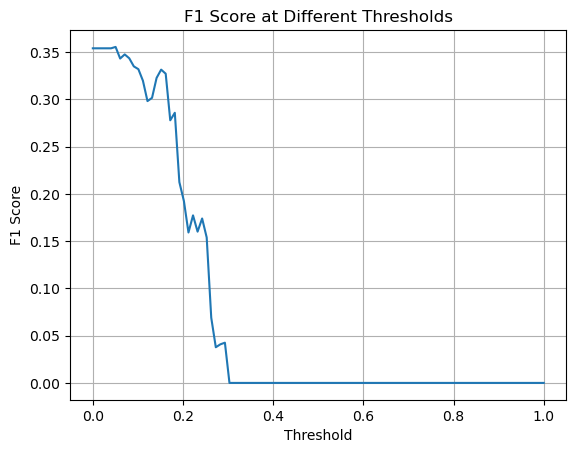

In [22]:
# Generate predictions on the test set
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.2).astype(int)

# Compute the F1 score at each epoch
f1_scores = [f1_score(y_test, (y_pred_probs > threshold).astype(int)) for threshold in np.linspace(0, 1, 100)]

# Find the threshold that gives the highest F1 score
best_threshold = np.linspace(0, 1, 100)[np.argmax(f1_scores)]
print("Best Threshold for F1 Score:", best_threshold)

# Plot the F1 score
plt.plot(np.linspace(0, 1, 100), f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score at Different Thresholds')
plt.grid(True)
plt.show()